# Decompose Transports into Streamfunction And Purely Divergent Component

Here we apply such [Helmholtz Decomposition](https://en.wikipedia.org/wiki/Helmholtz_decomposition) to vertically integrated transports defined over a Global Ocean model (`C-grid`).

1. read vertically integrated transport from file
2. compute its convergence and apply land mask
3. decompose into rotational and divergent components
4. derive streamfunction from the rotational component

### Read Model Grid & Transports From File

1. pre-requisites
2. read variables

In [1]:
#]add MITgcmTools#gfdev01

In [2]:
using MeshArrays, Plots, Statistics, MITgcmTools
include("helper_functions.jl")
get_grid_if_needed()

In [3]:
mypath="../inputs/GRID_LLC90/"
mygrid=GridSpec("LatLonCap",mypath)
GridVariables=GridLoad(mygrid)
(TrspX, TrspY, TauX, TauY, SSH)=trsp_read(mygrid,mypath)
SPM,lon,lat=read_SPM(mypath);

### Transport Convergence And Land Mask

_note: masking avoids isolated Canyons / singular matrices_

In [4]:
TrspCon=convergence(TrspX,TrspY)

msk=1.0 .+ 0.0 * mask(view(GridVariables["hFacC"],:,1),NaN,0.0)
TrspCon=msk*TrspCon;

### Helmholtz Decomposition

1. compute scalar potential
2. subtract divergent component
3. compute vector potential / streamfunction

In [5]:
#scalar potential
TrspPot=ScalarPotential(TrspCon)

#Divergent transport component
(TrspXdiv,TrspYdiv)=gradient(TrspPot,GridVariables)
TrspXdiv=TrspXdiv.*GridVariables["DXC"]
TrspYdiv=TrspYdiv.*GridVariables["DYC"]

#Rotational transport component
TrspXrot = TrspX-TrspXdiv
TrspYrot = TrspY-TrspYdiv

#vector Potential
TrspPsi=VectorPotential(TrspX,TrspY,GridVariables);

### Verify The Results Consistency

_TrspCon-tmpCon should be negligible compared with TrspCon_

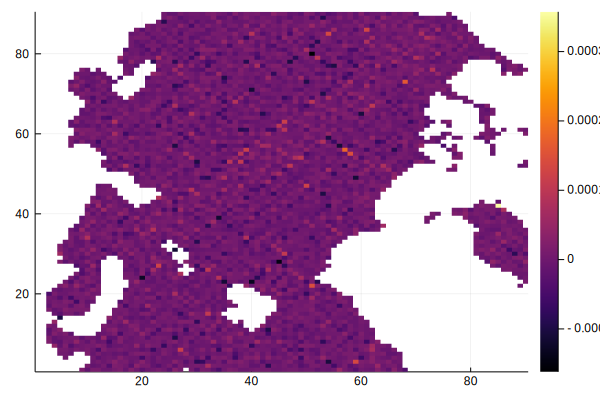

In [6]:
tmpCon=convergence(TrspXdiv,TrspYdiv)
tmp1=TrspCon[3]
tmp2=tmp1[findall(isfinite.(tmp1))]
errCon=1/sqrt(mean(tmp2.^2)).*(tmpCon[3]-TrspCon[3])
heatmap(errCon)

### Map Out Streamfunction And Scalar Potential

_Interpolation is used to readily create global maps_

In [7]:
TrspPsiI=MatrixInterp(write(1e-6*msk*TrspPsi),SPM,size(lon))
contourf(vec(lon[:,1]),vec(lat[1,:]),transpose(TrspPsiI),
    title="Streamfunction",clims=(-50,50))

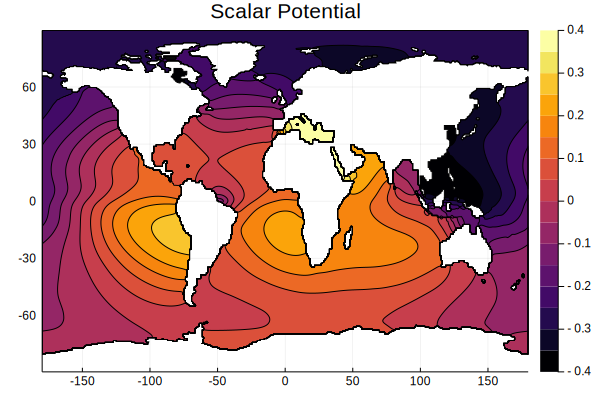

In [8]:
TrspPotI=MatrixInterp(write(1e-6*msk*TrspPot),SPM,size(lon))
contourf(vec(lon[:,1]),vec(lat[1,:]),transpose(TrspPotI),
    title="Scalar Potential",clims=(-0.4,0.4))